# Machine Learning Model Building Pipeline: Big Data, Images and Neural Networks


## Imports

In [5]:
import pandas as pd 
import numpy as np

# navigate folders
from glob import glob
import os

# for plotting 
import matplotlib.pyplot as plt 
%matplotlib inline

# to open the images 
import cv2 

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

# data preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# evaluate model and separate train and test
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# for the convolutional network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.optimizers import Adam 
from keras.metrics import categorical_crossentropy 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  
from keras.utils import np_utils

## Load Images / Data

In [7]:
# here are all our images
DATA_FOLDER = 'v2-plant-seedlings-dataset'

In [8]:
# each weed class is in a dedicated folder
os.listdir(DATA_FOLDER)

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'nonsegmentedv2',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [18]:
# let's wal over the directory structure, so we understand hot the images are stored

for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_name = os.path.join(DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_name, "*.png")):
        print(image_path)

v2-plant-seedlings-dataset\Black-grass\1.png
v2-plant-seedlings-dataset\Black-grass\10.png
v2-plant-seedlings-dataset\Black-grass\100.png
v2-plant-seedlings-dataset\Black-grass\101.png
v2-plant-seedlings-dataset\Black-grass\102.png
v2-plant-seedlings-dataset\Black-grass\103.png
v2-plant-seedlings-dataset\Black-grass\104.png
v2-plant-seedlings-dataset\Black-grass\105.png
v2-plant-seedlings-dataset\Black-grass\106.png
v2-plant-seedlings-dataset\Black-grass\107.png
v2-plant-seedlings-dataset\Black-grass\108.png
v2-plant-seedlings-dataset\Black-grass\109.png
v2-plant-seedlings-dataset\Black-grass\11.png
v2-plant-seedlings-dataset\Black-grass\110.png
v2-plant-seedlings-dataset\Black-grass\111.png
v2-plant-seedlings-dataset\Black-grass\112.png
v2-plant-seedlings-dataset\Black-grass\113.png
v2-plant-seedlings-dataset\Black-grass\114.png
v2-plant-seedlings-dataset\Black-grass\115.png
v2-plant-seedlings-dataset\Black-grass\116.png
v2-plant-seedlings-dataset\Black-grass\117.png
v2-plant-seedling

In [26]:
# lets crate a dataframe:
# the datframe stores the path to the image in a one column
# and the class of the weed (the target) in the next column

images_df = []

# navigate within each folder
for class_folder_name in os.listdir(DATA_FOLDER):
    class_folder_path = os.path.join(DATA_FOLDER, class_folder_name)

    # collect every image path
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        tmp = pd.DataFrame([image_path, class_folder_name]).T
        images_df.append(tmp)

print(images_df)
# concatenate the final df
images_df = pd.concat(images_df, axis=0, ignore_index=True)
images_df.columns = ['image', 'target']
images_df.head(10)

[                                              0            1
0  v2-plant-seedlings-dataset\Black-grass\1.png  Black-grass,                                                0            1
0  v2-plant-seedlings-dataset\Black-grass\10.png  Black-grass,                                                 0            1
0  v2-plant-seedlings-dataset\Black-grass\100.png  Black-grass,                                                 0            1
0  v2-plant-seedlings-dataset\Black-grass\101.png  Black-grass,                                                 0            1
0  v2-plant-seedlings-dataset\Black-grass\102.png  Black-grass,                                                 0            1
0  v2-plant-seedlings-dataset\Black-grass\103.png  Black-grass,                                                 0            1
0  v2-plant-seedlings-dataset\Black-grass\104.png  Black-grass,                                                 0            1
0  v2-plant-seedlings-dataset\Black-grass\105.png  Bl

image       target
0    v2-plant-seedlings-dataset\Black-grass\1.png  Black-grass
1   v2-plant-seedlings-dataset\Black-grass\10.png  Black-grass
2  v2-plant-seedlings-dataset\Black-grass\100.png  Black-grass
3  v2-plant-seedlings-dataset\Black-grass\101.png  Black-grass
4  v2-plant-seedlings-dataset\Black-grass\102.png  Black-grass
5  v2-plant-seedlings-dataset\Black-grass\103.png  Black-grass
6  v2-plant-seedlings-dataset\Black-grass\104.png  Black-grass
7  v2-plant-seedlings-dataset\Black-grass\105.png  Black-grass
8  v2-plant-seedlings-dataset\Black-grass\106.png  Black-grass
9  v2-plant-seedlings-dataset\Black-grass\107.png  Black-grass

In [28]:
# hoy many images do we've got per class?
# this should give similar results to what we observed
# when we inspected the length of image list in the dictionary

# There is class imbalance, but we will ignore it.

images_df['target'].value_counts()

Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
Shepherds Purse              274
Maize                        257
Common wheat                 253
Name: target, dtype: int64

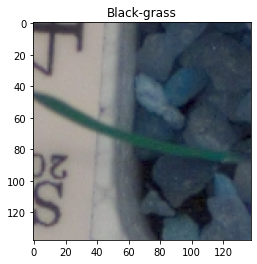

In [29]:
# let's visualise a few images
# if the iamges you see in your notebook are not the same, don't

def plot_single_image(df, image_number):
    im = cv2.imread(df.loc[image_number, 'image'])
    plt.title(df.loc[image_number, 'target'])
    plt.imshow(im)

plot_single_image(images_df, 0)

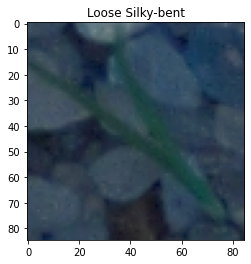

In [31]:
plot_single_image(images_df, 3000)

In [34]:
# let's go ahead and plot a bunch of our images together,
# so we get a better feeling of how our images look like

def plot_for_class(df, label):
    # function plots 9 images
    nb_rows = 3
    nb_cols = 3

    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            tmp = df[df['target'] == label]
            tmp.reset_index(drop=True, inplace=True)
            im = cv2.imread(tmp.loc[n, 'image'])
            axs[i, j].imshow(im)
            n += 1

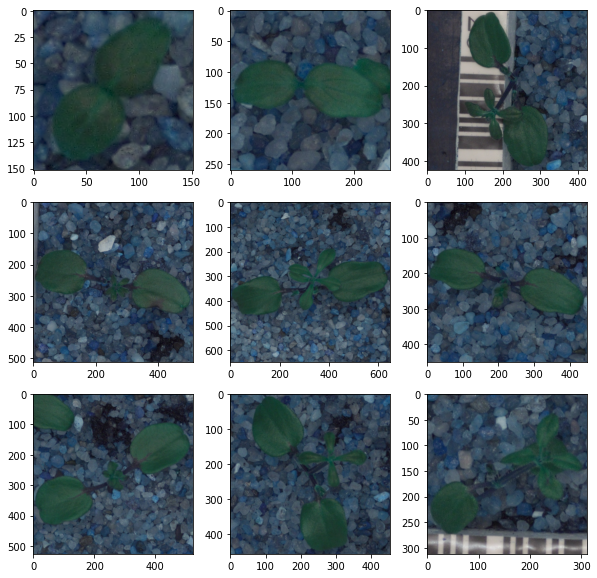

In [36]:
plot_for_class(images_df, 'Cleavers')